# Generate Forces and other info using OpenMM

In [1]:
import sys
print(sys.version)
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
!bash Miniconda3-py*.sh -bfp /usr/local
!conda config --set always_yes yes
!conda config --add channels conda-forge
!conda create -n openmm python=3.7 cudatoolkit=10.0 git jupyterlab matplotlib ipympl rdkit openbabel openmm mdtraj pymbar pdbfixer parmed openff-toolkit openmoltools openmmforcefields
sys.path.append('/usr/local/envs/openmm/lib/python3.7/site-packages')
import openmm.testInstallation
openmm.testInstallation.main()

3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]
--2022-04-20 17:54:06--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89026327 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.10.3-Linux-x86_64.sh’

Miniconda3-py37_4.1 100%[===================>]  84.90M  84.0MB/s    in 1.0s    

2022-04-20 17:54:07 (84.0 MB/s) - ‘Miniconda3-py37_4.10.3-Linux-x86_64.sh’ saved [89026327/89026327]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py37h27cfd23_1003
    - ca-certificates==2021.7.5=h06a4308_1
    - certifi==2021.5.30=py37

In [2]:
%matplotlib widget
from sys import stdout

import matplotlib.pyplot as plt
import mdtraj
#import nglview
import numpy as np
import pandas
from openmm import *
from openmm.app import *
from openmm.unit import *

In [ ]:
# The print lines below show details of the topology.
topology = pdb.topology

print(topology)
print("Number of atoms:", topology.getNumAtoms())
print("Periodic boundaries:", topology.getUnitCellDimensions())
for iatom, atom in enumerate(topology.atoms()):
    # The following-line would just print a dictionary
    # with all attributes, useful to explore undocumented
    # attributes.
    # print(vars(atom))
    print("Name and mass of atom {}: {}, {}".format(
        iatom, atom.name, atom.element.mass))

In [ ]:
# Loop over all contributions to the force evaluation.
# Note that not all terms are real force-field contributions.
# The last one zeros to center-of-mass momentum at every step.
for force in system.getForces():
    print(force)
print()
# The force field contains two harmonic bond terms,
# with the same parameters.
force_bond = system.getForce(0)
for ibond in range(force_bond.getNumBonds()):
    print(force_bond.getBondParameters(ibond))
    print()

force_angle = system.getForce(1)
for iang in range(force_angle.getNumAngles()):
    print(force_angle.getAngleParameters(iang))
    print()

force_torsion = system.getForce(2)
for itor in range(force_torsion.getNumTorsions()):
    print(force_torsion.getTorsionParameters(itor))
    print()

In [17]:
pdb = PDBFile('alanine-dipeptide.pdb')
forcefield = ForceField('amber14-all.xml')
system = forcefield.createSystem(pdb.topology, nonbondedCutoff=3*nanometer, constraints=HBonds)
integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 2*femtoseconds)
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)
simulation.minimizeEnergy()
simulation.reporters.append(PDBReporter('output.pdb', 1000))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True, volume=True, density=True,
        potentialEnergy=True, temperature=True))

for i in range(1):
    simulation.step(1000)
    state0 = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)

    print("Potential energy")
    print(state0.getPotentialEnergy())

    print("Atomic positions")
    print(state0.getPositions(asNumpy=True))

    print("Volume")
    print(state0.getPeriodicBoxVolume())

    print("Forces")
    print(state0.getForces(asNumpy=True))

#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)","Density (g/mL)"
1000,-23.572113037109375,217.79489612900085,8.0,0.029926235068607063
Potential energy
-23.572113037109375 kJ/mol
Atomic positions
[[ 0.28224531  0.28850573 -0.30827859]
 [ 0.23036176  0.2743094  -0.213476  ]
 [ 0.17216794  0.18351936 -0.19761248]
 [ 0.16438875  0.36058307 -0.20422974]
 [ 0.33652744  0.28915098 -0.10330004]
 [ 0.36405116  0.19556376 -0.03305268]
 [ 0.38611719  0.41228706 -0.10150412]
 [ 0.37584543  0.47419196 -0.18064497]
 [ 0.46934566  0.45456266  0.00928953]
 [ 0.45221016  0.40578291  0.10524738]
 [ 0.60858858  0.39986467 -0.02696783]
 [ 0.63723552  0.4401626  -0.1241091 ]
 [ 0.67827219  0.43347755  0.0498136 ]
 [ 0.6041671   0.29108509 -0.02163297]
 [ 0.4722524   0.60736388  0.03981034]
 [ 0.40987849  0.68998981 -0.03201741]
 [ 0.55067688  0.64454782  0.1404456 ]
 [ 0.61279637  0.57833946  0.1847021 ]
 [ 0.55873889  0.77851164  0.19154648]
 [ 0.47560224  0.81035334  0.25443888

# Output pdb file

In [ ]:
pdb = PDBFile('output.pdb')
temp_pos = pdb.positions

pdb = PDBFile('alanine-dipeptide.pdb')
forcefield = ForceField('amber14-all.xml')
system = forcefield.createSystem(pdb.topology, nonbondedCutoff=3*nanometer, constraints=HBonds)
integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 2*femtoseconds)
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(temp_pos)

state0 = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)

print("Potential energy")
print(state0.getPotentialEnergy())

Potential energy
-32.717681884765625 kJ/mol


In [ ]:
state0 = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)

print("Potential energy")
print(state0.getPotentialEnergy())

print("Kinetic energy")
print(state0.getKineticEnergy())

print("Parameters")
print(state0.IntegratorParameters)

print("Atomic positions")
print(state0.getPositions(asNumpy=True))
print()

print("Forces")
print(state0.getForces(asNumpy=True))

Potential energy
-32.902130126953125 kJ/mol
Kinetic energy
90.11922410875559 kJ/mol
Parameters
64
Atomic positions
[[ 0.70409751  0.60591584 -0.19894679]
 [ 0.73379332  0.51515102 -0.14640231]
 [ 0.80561393  0.55400074 -0.07419775]
 [ 0.77003974  0.43802121 -0.21436022]
 [ 0.61272919  0.45290676 -0.07554523]
 [ 0.59413809  0.33243299 -0.07721817]
 [ 0.54840052  0.53903508  0.00634521]
 [ 0.57134056  0.63738817  0.00756338]
 [ 0.44523358  0.49068999  0.09538831]
 [ 0.47594991  0.38833541  0.11686075]
 [ 0.44742814  0.56700867  0.22271752]
 [ 0.54654789  0.55988789  0.26750112]
 [ 0.42304239  0.67186356  0.20563297]
 [ 0.36884266  0.53160286  0.28943908]
 [ 0.30610096  0.49585739  0.03096288]
 [ 0.20545314  0.53835398  0.08379367]
 [ 0.30242556  0.42872262 -0.08341246]
 [ 0.38799319  0.37929547 -0.10429641]
 [ 0.19098607  0.41772941 -0.16813381]
 [ 0.11850724  0.49858502 -0.15863721]
 [ 0.22000666  0.4220376  -0.27311116]
 [ 0.13325109  0.32731727 -0.14881119]] nm

Forces
[[ -228.2277941

In [ ]:
temp_pos = pdb.positions

[Vec3(x=0.2, y=0.1, z=-0.0), Vec3(x=0.2, y=0.209, z=0.0), Vec3(x=0.1486, y=0.24540000000000003, z=0.08900000000000001), Vec3(x=0.1486, y=0.24540000000000003, z=-0.08900000000000001), Vec3(x=0.3427, y=0.2641, z=-0.0), Vec3(x=0.43910000000000005, y=0.1877, z=-0.0), Vec3(x=0.35550000000000004, y=0.397, z=-0.0), Vec3(x=0.27330000000000004, y=0.4556, z=-0.0), Vec3(x=0.4853, y=0.46140000000000003, z=-0.0), Vec3(x=0.5408000000000001, y=0.4316, z=0.08900000000000001), Vec3(x=0.5660999999999999, y=0.42210000000000003, z=-0.1232), Vec3(x=0.5123000000000001, y=0.4521, z=-0.21309999999999998), Vec3(x=0.663, y=0.47190000000000004, z=-0.1206), Vec3(x=0.5809000000000001, y=0.31410000000000005, z=-0.12410000000000002), Vec3(x=0.47130000000000005, y=0.6129, z=0.0), Vec3(x=0.36010000000000003, y=0.6653, z=0.0), Vec3(x=0.5846, y=0.6835, z=0.0), Vec3(x=0.6737000000000001, y=0.6359, z=-0.0), Vec3(x=0.5846, y=0.8284000000000001, z=0.0), Vec3(x=0.4819, y=0.8648, z=0.0), Vec3(x=0.6360000000000001, y=0.8648, z

# Loading Images

In [24]:
import numpy as np

# For math and stats operations
from scipy.spatial.transform import Rotation as R
from scipy.stats import multivariate_normal

# For plotting
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly

# For saving and loading
import pickle
%matplotlib inline

num_imgs = 50

In [25]:
# Generate rotation matrices
rot_mats = []
for n in range(num_imgs):
    r = R.from_euler('zyx', [[np.random.uniform(0, 2*np.pi), np.random.uniform(0, np.pi), np.random.uniform(0, 2*np.pi)]],
                     degrees=False)
    rot_mats.append(r.as_matrix()[0])

In [42]:
def createblobs(coords, Q=1, n_cells=51, scale=0.001, noise=25, rot_mat=np.eye(3)):
    # Grids of x and y points
    x = np.linspace(-Q, Q, n_cells)
    y = np.linspace(-Q, Q, n_cells)
    # Create a 2-D meshgrid of (x, y) coordinates.
    x, y = np.meshgrid(x, y)

    normals = np.zeros_like(x)

    # Creating mixture of gaussians
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y

    new_coords = np.asarray(coords) @ rot_mat.T

    for row in new_coords:
        var = multivariate_normal(mean=row[0:2], cov=scale*np.eye(2))
        normals = normals + var.pdf(pos)

    normals = normals + np.abs(np.random.normal(0, noise, size=normals.shape))
    return normals

In [43]:
pot_energies = []
forces_list = []
pos_list = []
img_list = []

for i in range(num_imgs):
    simulation.step(1000)
    state0 = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)

    pot_energies.append(state0.getPotentialEnergy())
    pos_list.append(state0.getPositions(asNumpy=True))
    forces_list.append(state0.getForces(asNumpy=True))
    img_list.append(createblobs(pos_list[-1], Q=1, n_cells=51, scale=0.001, noise=25, rot_mat=rot_mats[i]))

352000,-34.40771484375,520.3574563958647,8.0,0.029926235068607063
353000,-26.1783447265625,249.7313612346264,8.0,0.029926235068607063
354000,-26.769866943359375,327.1709225774937,8.0,0.029926235068607063
355000,-30.78729248046875,397.0430020862788,8.0,0.029926235068607063
356000,-4.2095947265625,240.0134632792449,8.0,0.029926235068607063
357000,-23.6287841796875,407.4048424211161,8.0,0.029926235068607063
358000,-27.487274169921875,325.1220953231535,8.0,0.029926235068607063
359000,-19.7510986328125,255.2765843026198,8.0,0.029926235068607063
360000,-3.0802001953125,249.0281936072065,8.0,0.029926235068607063
361000,-30.206207275390625,331.5467940695883,8.0,0.029926235068607063
362000,-12.06707763671875,246.9497466655166,8.0,0.029926235068607063
363000,-29.552764892578125,299.5734519299609,8.0,0.029926235068607063
364000,-10.053558349609375,404.41375904715187,8.0,0.029926235068607063
365000,-41.29168701171875,424.1603375098034,8.0,0.029926235068607063
366000,-25.948211669921875,306.1007926

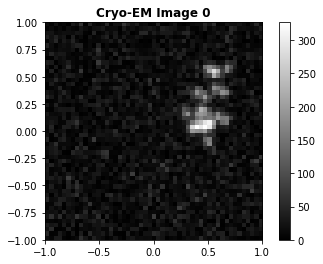

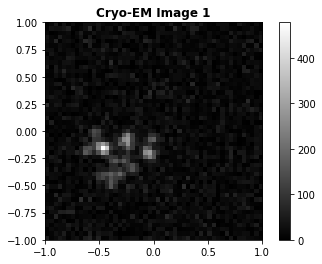

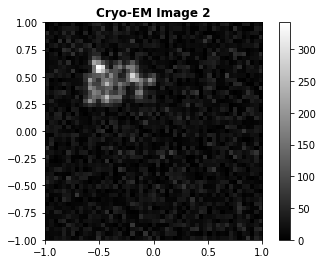

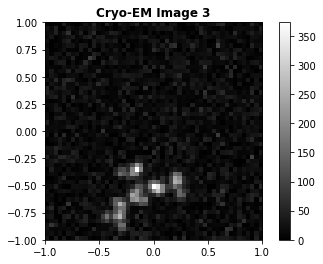

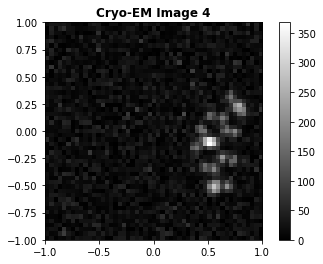

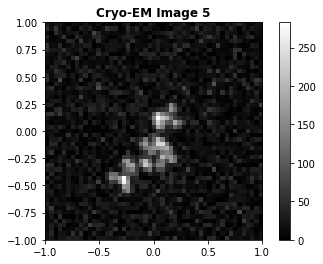

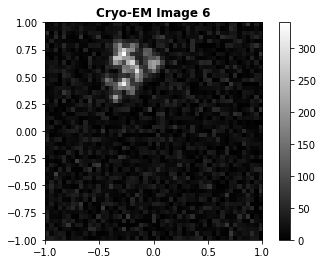

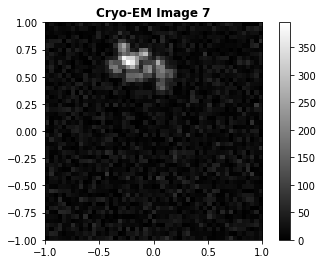

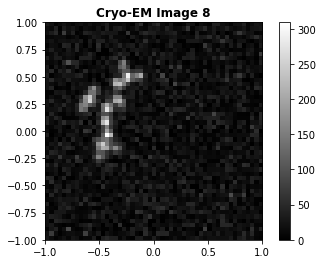

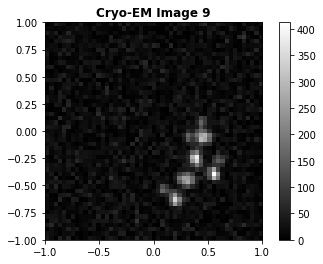

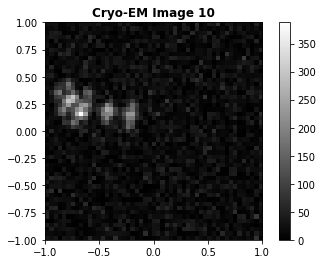

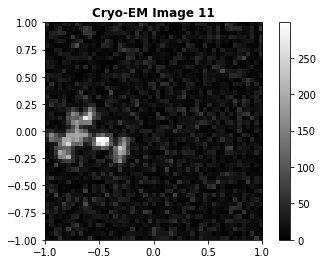

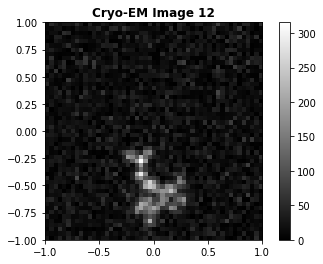

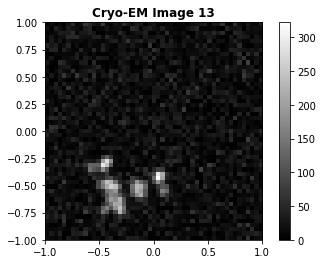

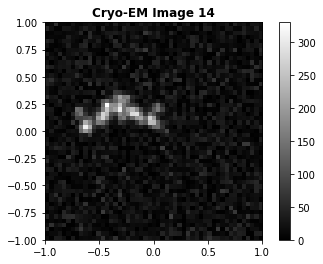

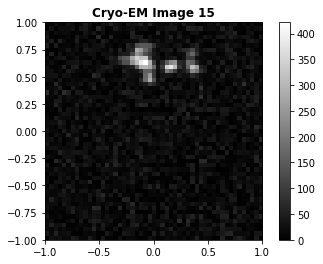

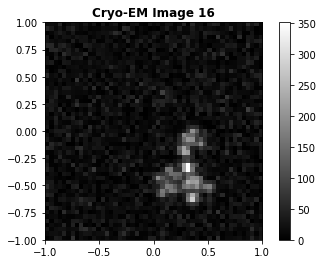

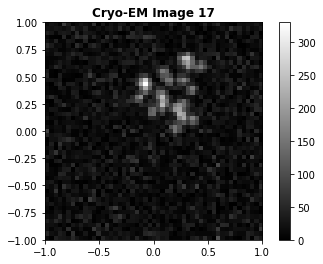

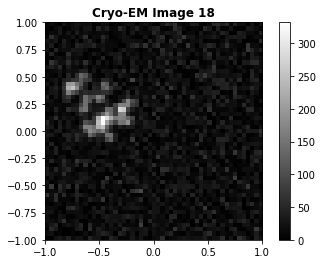

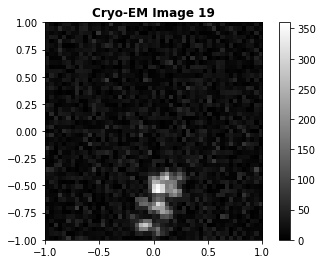

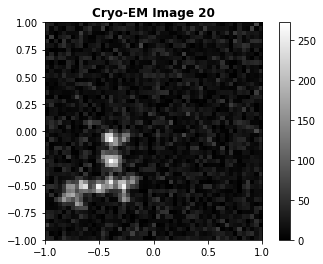

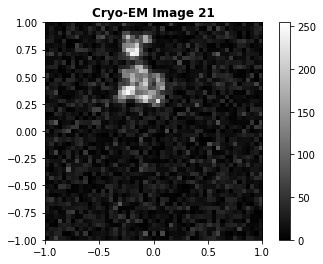

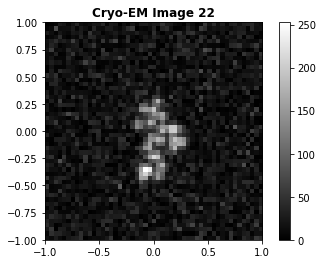

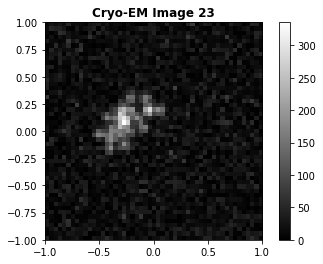

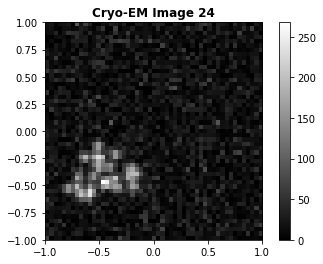

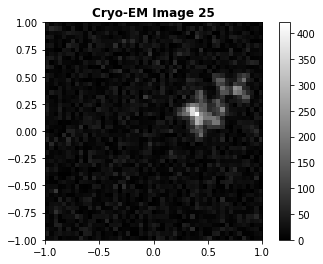

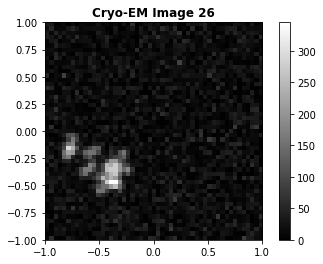

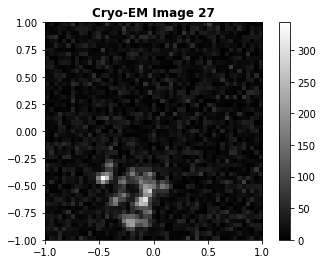

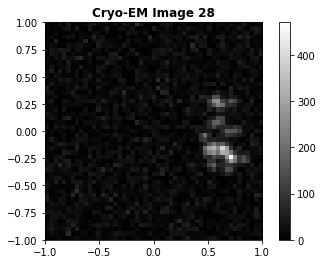

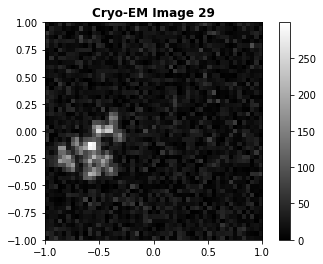

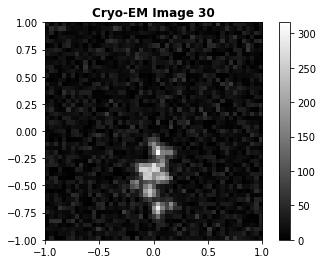

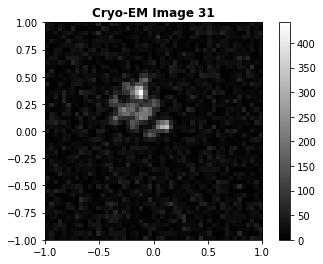

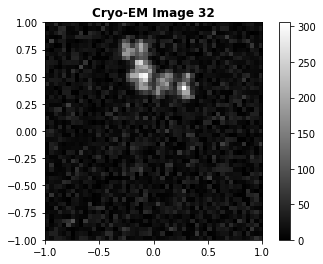

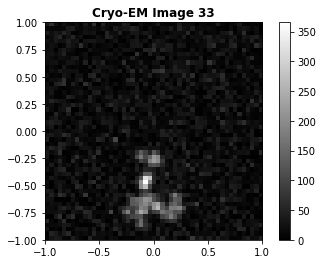

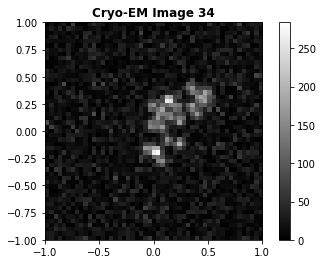

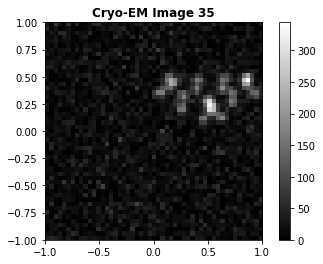

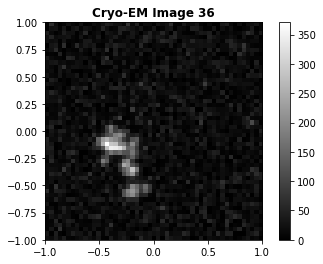

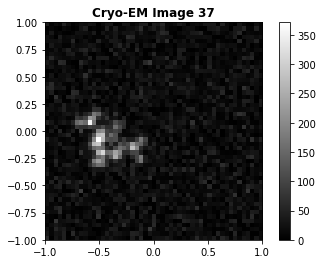

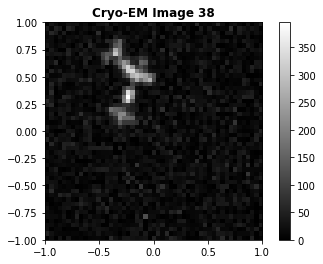

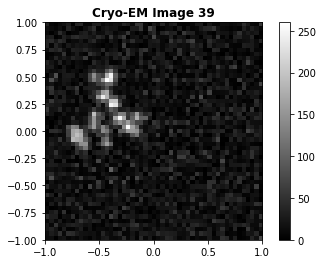

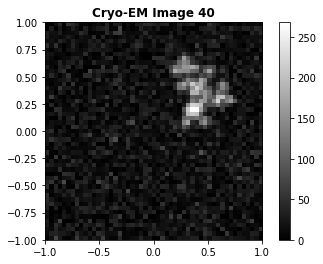

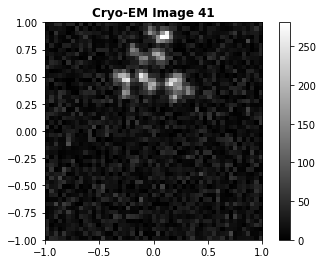

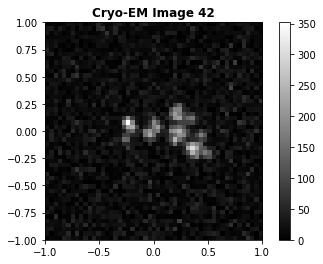

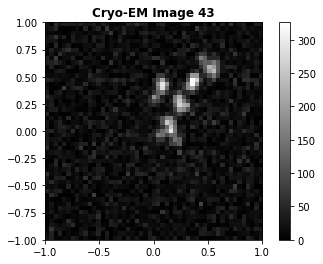

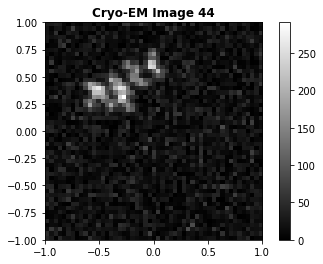

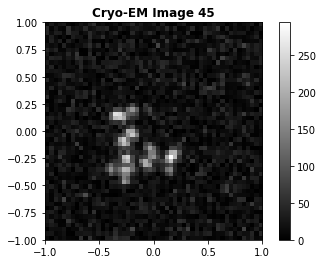

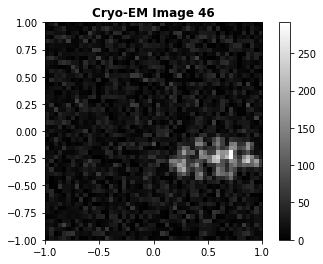

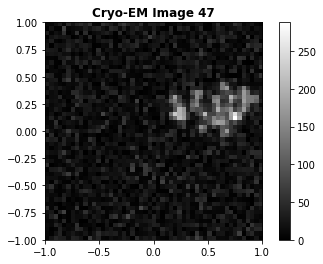

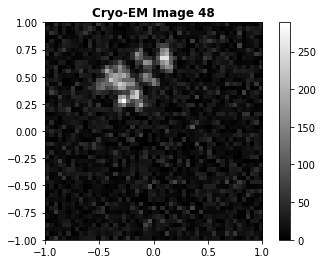

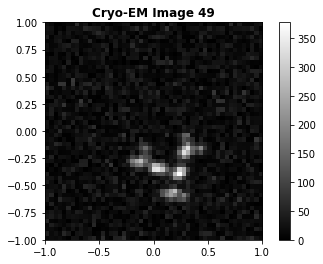

In [44]:
for idx, img in enumerate(img_list):
    c = plt.imshow(img, cmap ='gray', vmin = 0, vmax = np.abs(img).max(),\
                    extent = [-1, 1, -1, 1], interpolation = 'nearest', origin = 'lower')
    plt.colorbar(c)
                
    plt.title(f'Cryo-EM Image {idx}', fontweight = "bold")
    plt.show()

In [45]:
with open('adenine_dipeptide_50.pkl', 'wb') as outp:
    pickle.dump(rot_mats, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(pot_energies, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(forces_list, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(pos_list, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(img_list, outp, pickle.HIGHEST_PROTOCOL)

with open('adenine_dipeptide_50.pkl', 'rb') as inp:
    rots = pickle.load(inp)
    pots = pickle.load(inp)
    forces = pickle.load(inp)
    poss = pickle.load(inp)
    imgs = pickle.load(inp)

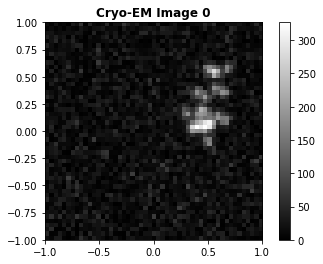

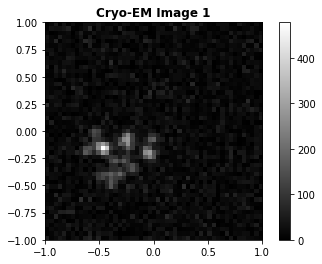

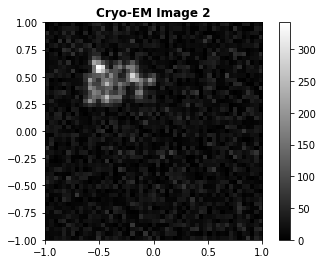

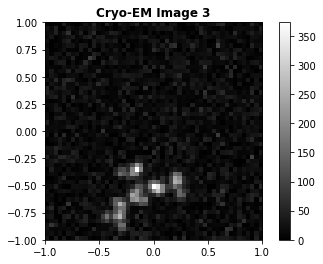

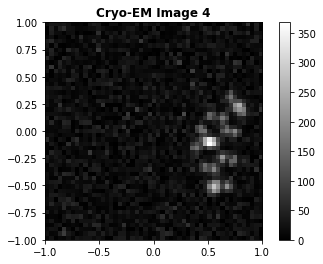

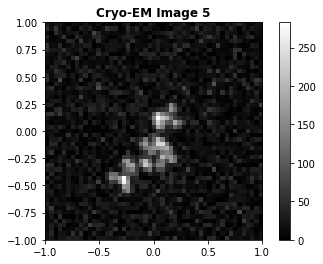

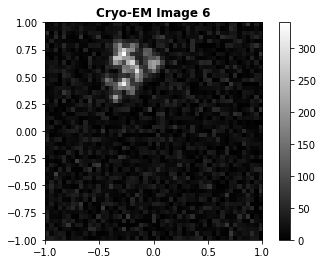

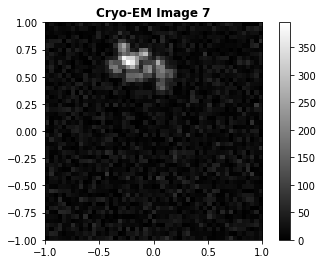

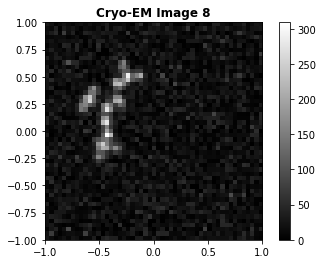

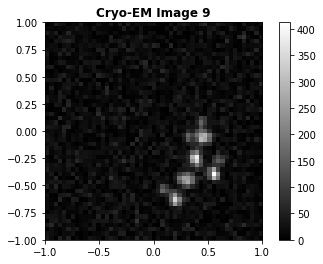

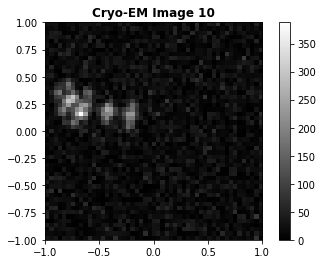

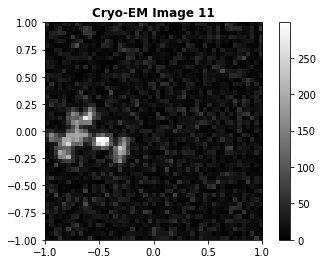

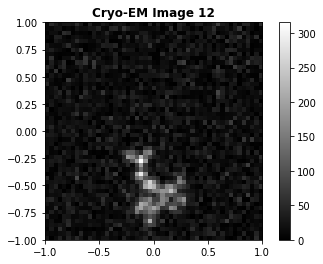

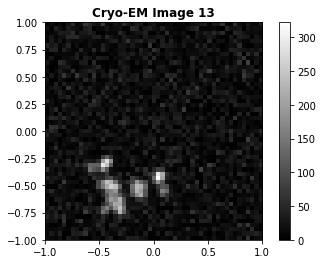

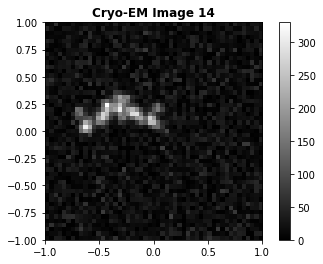

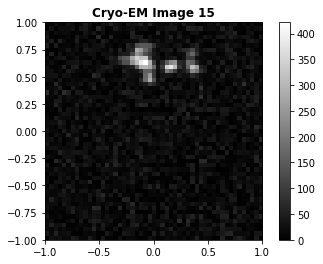

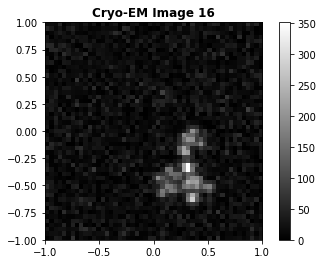

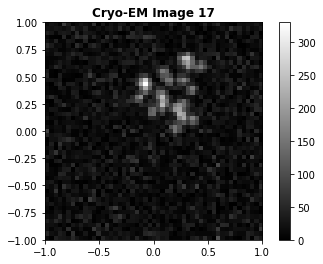

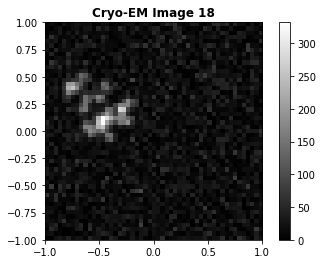

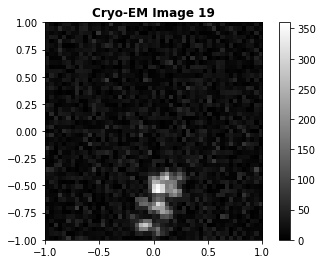

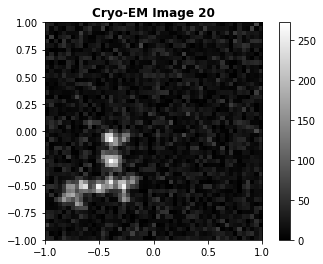

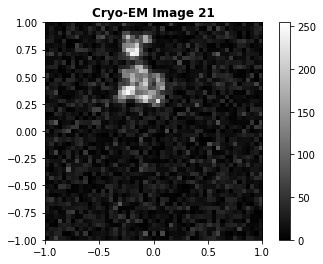

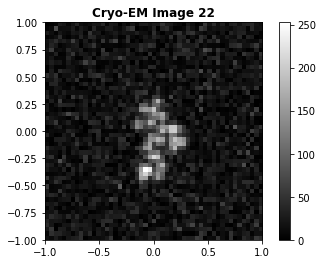

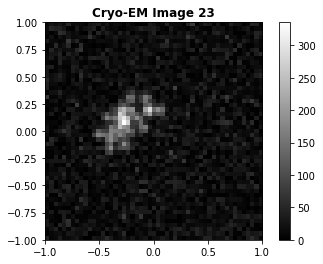

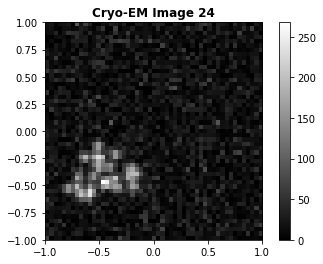

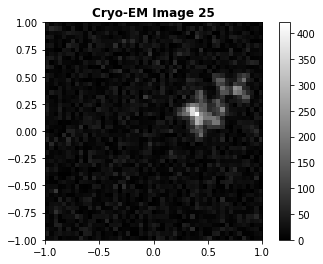

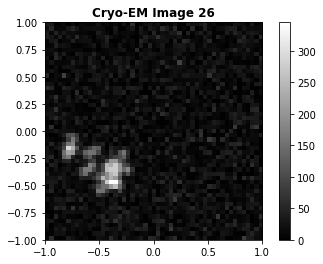

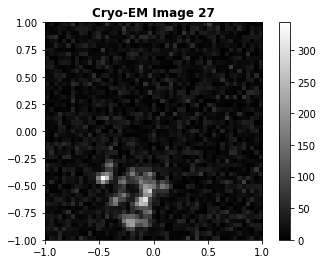

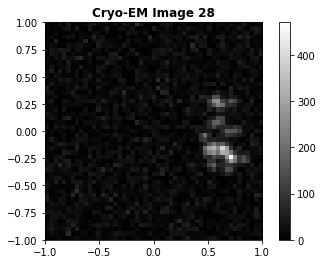

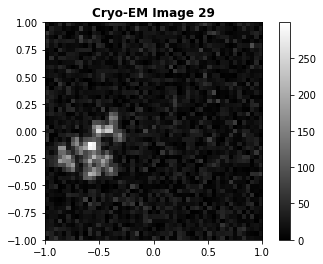

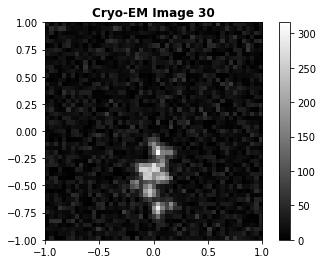

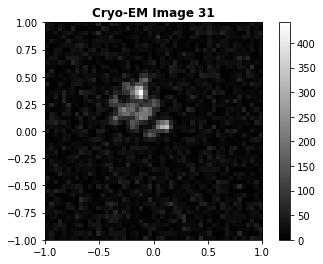

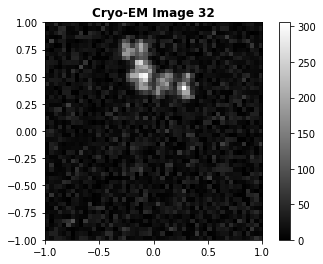

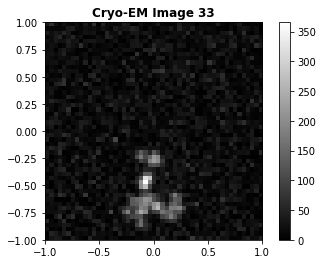

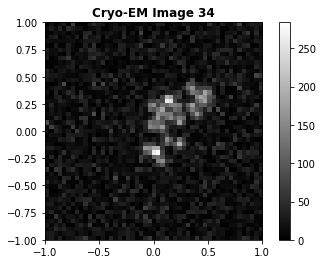

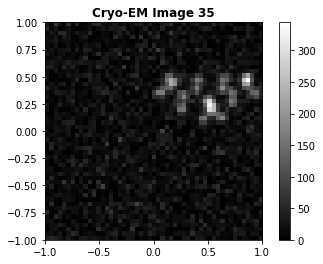

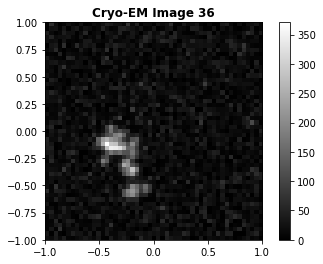

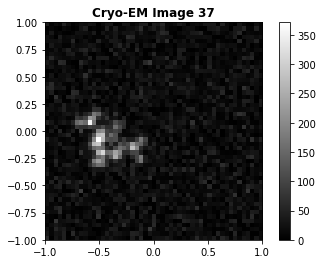

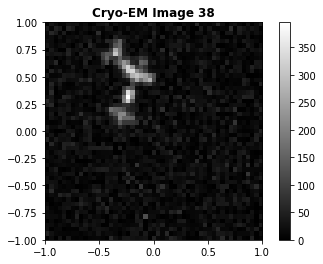

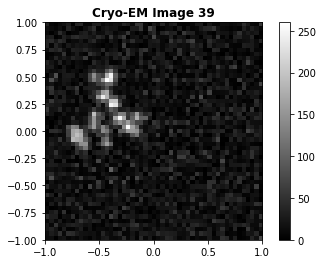

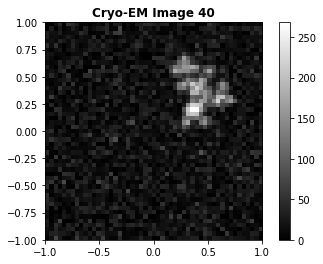

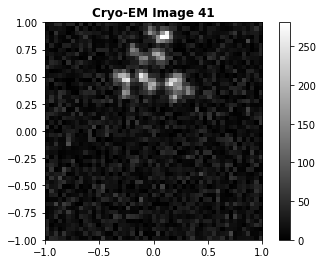

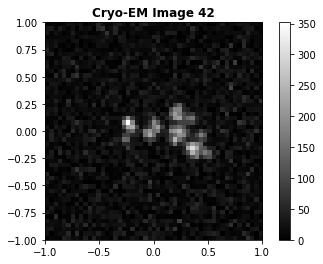

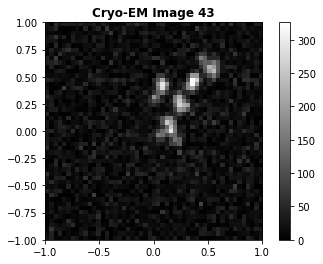

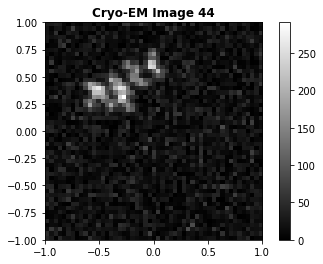

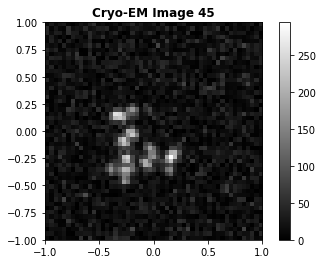

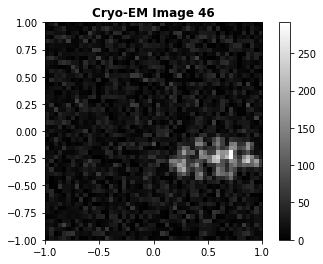

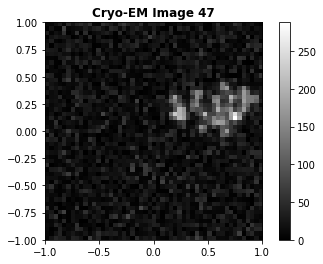

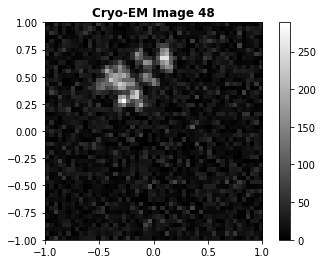

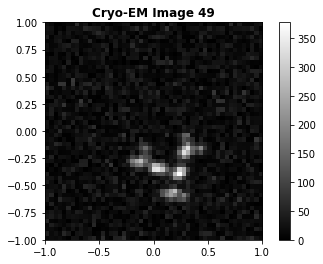

In [47]:
for idx, img in enumerate(imgs):
    c = plt.imshow(img, cmap ='gray', vmin = 0, vmax = np.abs(img).max(),\
                    extent = [-1, 1, -1, 1], interpolation = 'nearest', origin = 'lower')
    plt.colorbar(c)
                
    plt.title(f'Cryo-EM Image {idx}', fontweight = "bold")
    plt.show()

# Architecture

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [75]:
def torch_createblobs(coords, Q=1, n_cells=51, scale=0.001, noise=25, rot_mat=torch.eye(3)):
    # Grids of x and y points
    x = torch.linspace(-Q, Q, n_cells)
    y = torch.linspace(-Q, Q, n_cells)
    # Create a 2-D meshgrid of (x, y) coordinates.
    x, y = torch.meshgrid(x, y, indexing='xy')

    normals = torch.zeros_like(x)

    # Creating mixture of gaussians
    pos = torch.empty(x.shape + (2,)).double()
    pos[:, :, 0] = x
    pos[:, :, 1] = y

    new_coords = coords @ rot_mat.T

    for row in new_coords.double():
        var = torch.distributions.multivariate_normal.MultivariateNormal(row[0:2], scale*torch.eye(2).double())
        normals = normals + torch.exp(var.log_prob(pos))

    return normals

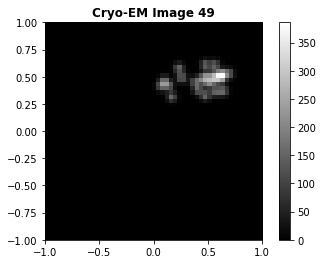

In [78]:
x0 = torch.tensor(np.asarray(state0.getPositions(asNumpy=True)))
temptest = torch_createblobs(x0, Q=1, n_cells=51, scale=0.001, noise=25, rot_mat=torch.eye(3).double())

c = plt.imshow(temptest, cmap ='gray', vmin = 0, vmax = np.abs(temptest).max(),\
                extent = [-1, 1, -1, 1], interpolation = 'nearest', origin = 'lower')
plt.colorbar(c)
                
plt.title(f'Cryo-EM Image {idx}', fontweight = "bold")
plt.show()

In [ ]:
class architecture(nn.Module):
    def __init__(self, n_cells=51, template=x0):
        super().__init__()
        self.template = template

        self.mlp = nn.Sequential(
            nn.Linear(3, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 3)
        )

    def torch_createblobs(self, coords, Q=1, n_cells=51, scale=0.001, noise=25, rot_mat=torch.eye(3)):
        # Grids of x and y points
        x = torch.linspace(-Q, Q, n_cells)
        y = torch.linspace(-Q, Q, n_cells)
        # Create a 2-D meshgrid of (x, y) coordinates.
        x, y = torch.meshgrid(x, y, indexing='xy')

        normals = torch.zeros_like(x)

        # Creating mixture of gaussians
        pos = torch.empty(x.shape + (2,)).double()
        pos[:, :, 0] = x
        pos[:, :, 1] = y

        new_coords = (self.template + self.mlp(coords - self.template)) @ rot_mat.T

        for row in new_coords.double():
            var = torch.distributions.multivariate_normal.MultivariateNormal(row[0:2], scale*torch.eye(2).double())
            normals = normals + torch.exp(var.log_prob(pos))

        return normals
    

    def forward(self, coords, rotmat_list):
        for i in range(len(img_list)):
            coords = self.template + self.mlp(img_list[i] - self.template)
            
        for rot in rotmat_list:
            rotated_coords = torch.mm(new_coords, torch.tensor(rot, dtype=torch.float).T)
            #print(len(recons_imgs))
            recons_img = self.gaussian_blobs(rotated_coords)
            recons_imgs.append(recons_img)
        
        return torch.stack(recons_imgs)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

# Testing right side of pipeline (please ignore)

In [ ]:
def gaussian_blobs(coord_list, n_cells=51):
    image = torch.zeros((n_cells, n_cells))
    axes_coord = np.linspace(-q, q, num=n_cells)
    x,y = np.meshgrid(axes_coord, axes_coord)
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    image_mat = torch.tensor(pos, dtype=torch.double)

    for coord in coord_list:
        m = torch.distributions.multivariate_normal.MultivariateNormal(coord[:2].type(torch.double),\
                                                        (10.0/3)*torch.eye(2, dtype=torch.double))
        image = image + m.log_prob(image_mat).exp()

    return image/(2*q/n_cells)

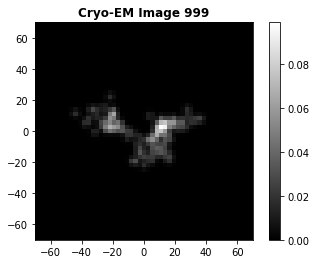

In [ ]:
"""
img_list = []

for i in range(len(imgs)):
    conformation = atmcrd[i] #possc[conf[i]]
    rotation = rot[i]

    x = conformation[0][:2, 0]
    y = conformation[0][:2, 1]
    z = conformation[0][:2, 2]

    for triangle in conformation:
        x = np.append(x, triangle[2, 0])
        y = np.append(y, triangle[2, 1])
        z = np.append(z, triangle[2, 2])

    target_coords = np.hstack((x[:,None],y[:,None],z[:,None]))
    r = R.from_euler('zyz', rotation)
    rot_mat = r.as_matrix()

    rotated_coords = torch.mm(torch.tensor(target_coords, dtype=torch.float), torch.tensor(rot_mat, dtype=torch.float).T)

    img_aliter = gaussian_blobs(rotated_coords)
    img_list.append(img_aliter)

print(len(img_list))"""

c = plt.imshow(np.abs(img_list[0]), cmap ='gray', vmin = 0, vmax = np.abs(img_list[0]).max(),\
                extent = [-q, q, -q, q], interpolation = 'nearest', origin = 'lower')
plt.colorbar(c)
                
plt.title(f'Cryo-EM Image {i}', fontweight = "bold")
plt.show()

In [ ]:
for i in range(len(img_list)):
    mse_list = []
    for conformation in possc:
        rotation = rot[i]

        x = conformation[0][:2, 0]
        y = conformation[0][:2, 1]
        z = conformation[0][:2, 2]

        for triangle in conformation:
            x = np.append(x, triangle[2, 0])
            y = np.append(y, triangle[2, 1])
            z = np.append(z, triangle[2, 2])

        target_coords = np.hstack((x[:,None],y[:,None],z[:,None]))
        r = R.from_euler('zyz', rotation)
        rot_mat = r.as_matrix()

        rotated_coords = torch.mm(torch.tensor(target_coords, dtype=torch.float), torch.tensor(rot_mat, dtype=torch.float).T)
        img_aliter = gaussian_blobs(rotated_coords)
        mse_list.append(torch.linalg.norm(img_aliter - img_list[i]))

    print([torch.argmin(torch.tensor(mse_list)), conf[i]])

[tensor(7), 7]
[tensor(2), 2]
[tensor(5), 5]
[tensor(4), 4]
[tensor(0), 0]
[tensor(5), 5]
[tensor(6), 6]
[tensor(8), 8]
[tensor(3), 3]
[tensor(7), 7]
[tensor(9), 9]
[tensor(4), 4]
[tensor(2), 2]
[tensor(8), 8]
[tensor(0), 0]
[tensor(1), 1]
[tensor(0), 0]
[tensor(1), 1]
[tensor(0), 0]
[tensor(9), 9]
[tensor(8), 8]
[tensor(9), 9]
[tensor(6), 6]
[tensor(5), 5]
[tensor(2), 2]
[tensor(6), 6]
[tensor(8), 8]
[tensor(4), 4]
[tensor(6), 6]
[tensor(1), 1]
[tensor(2), 2]
[tensor(3), 3]
[tensor(9), 9]
[tensor(9), 9]
[tensor(2), 2]
[tensor(8), 8]
[tensor(9), 9]
[tensor(4), 4]
[tensor(5), 5]
[tensor(0), 0]
[tensor(9), 9]
[tensor(5), 5]
[tensor(3), 3]
[tensor(7), 7]
[tensor(2), 2]
[tensor(1), 1]
[tensor(2), 2]
[tensor(1), 1]
[tensor(7), 7]
[tensor(9), 9]
[tensor(9), 9]
[tensor(2), 2]
[tensor(4), 4]
[tensor(3), 3]
[tensor(6), 6]
[tensor(1), 1]
[tensor(7), 7]
[tensor(4), 4]
[tensor(0), 0]
[tensor(0), 0]
[tensor(9), 9]
[tensor(0), 0]
[tensor(2), 2]
[tensor(7), 7]
[tensor(1), 1]
[tensor(5), 5]
[tensor(2)

KeyboardInterrupt: ignored